In [27]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



In [28]:
# Data Prerprocessing
samsung_code = "005930"    
skhynix_code = "000660"  

start_date = "2017-10-19"
end_date = "2019-10-31"

samsung_df = stock.get_market_ohlcv_by_date(start_date, end_date, samsung_code)
skhynix_df = stock.get_market_ohlcv_by_date(start_date, end_date, skhynix_code)


df = pd.DataFrame({'samsumg': samsung_df['종가'], 'skhynix': skhynix_df['종가']}).astype(float)



In [29]:
def monte_carlo_simulation(drift, volatility, epsilon, num_assets):
    dt = 1/252  # 일일 시간 간격
    log_returns = []
    for i in range(num_assets):
        log_return = (drift - 0.5 * volatility[i]**2) * dt + volatility[i] * np.sqrt(dt) * epsilon[i]
        log_returns.append(log_return)
    return np.array(log_returns)

In [30]:
def find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_up):
    if index < first and worst_performer[due_first] > EC_strike_rate:
            f1_up.append(first_payoff / np.exp(rf/252 * due_first))
    elif index < second and worst_performer[due_second] > EC_strike_rate:
        f1_up.append(second_payoff / np.exp(rf/252 * due_second))
    elif index < third and worst_performer[due_third] > EC_strike_rate:
        f1_up.append(third_payoff / np.exp(rf/252 * due_third))                  
    else:
        max_return = max(worst_performer[due_last], 0.95)
        f1_up.append(max_return)
    return

In [31]:
num_assets = 2
time_steps = 252
num_samples = 10000
rf = 0.015

df_index = df.iloc[252::20, :]
initial_price = df.iloc[252]
EC_strike_rate = 1.02
MC_strike_rate = 1.00
EC_strike_price = initial_price * EC_strike_rate
MC_strike_price = initial_price * MC_strike_rate
dt = 1/252

ELS_Delta1 = []
ELS_Delta2 = []

### 2018-10-31부터 20일단위로 rebalancing 진행
for index, names in df_index.iterrows():    
    print(index)
    simulated_S = []
    simulated_Su = []
    simulated_Sd = []
    
    # 리밸런싱 시점의 252 영업일 전부터의 데이터 가져오기
    init_price = df.loc[index]
    index_num = df.index.get_loc(index)
    df_hist = df.iloc[index_num-252:index_num, :]
        
    # MCMC로 10000개의 (2, 252) 누적 수익률 데이터 만들기
    cholesky_mat = np.linalg.cholesky(df_hist.corr())
    vol = np.log(df_hist/df_hist.shift(1))[1:].std() * np.sqrt(252)
        
    for _ in range(num_samples):                        
        epsilon = np.dot(cholesky_mat, np.random.randn(num_assets, time_steps))
        simulated_returns = monte_carlo_simulation(rf, vol, epsilon, num_assets)
        
        S = np.exp(np.cumsum((simulated_returns), axis=1))
        #S[0] *= init_price[0]
        #S[1] *= init_price[1]        
        Su = S.copy()
        Su[0] *= np.exp(vol[0]*np.sqrt(5*dt))
        Su[1] *= np.exp(vol[1]*np.sqrt(5*dt))
        Sd = S.copy()
        Sd[0] *= np.exp(-1*vol[0]*np.sqrt(5*dt))
        Sd[1] *= np.exp(-1*vol[1]*np.sqrt(5*dt))
        
        simulated_S.append(S)
        simulated_Su.append(Su)
        simulated_Sd.append(Sd)
                
    simulated_S = np.array(simulated_S)
    simulated_Su = np.array(simulated_Su)
    simulated_Sd = np.array(simulated_Sd)            
        
    ### ELS 가치평가
    first = datetime.strptime('2019-01-31', '%Y-%m-%d')
    second = datetime.strptime('2019-04-30', '%Y-%m-%d')
    third = datetime.strptime('2019-07-31', '%Y-%m-%d')
    last = datetime.strptime('2019-10-31', '%Y-%m-%d')
    
    f1_up = []
    f1_down = []
    f2_up = []
    f2_down = []
        
    first_payoff = 1.0159
    second_payoff = 1.0318
    third_payoff = 1.0477
        
    due_first = len(df.loc[:first]) - len(df.loc[:index])
    due_second = len(df.loc[:second]) - len(df.loc[:index])
    due_third = len(df.loc[:third]) - len(df.loc[:index])
    due_last = len(df.loc[:last]) - len(df.loc[:index])
        
    for S, Su, Sd in zip(simulated_S, simulated_Su, simulated_S):        
        
        # f1_up 구하기 : 기초자산1 상승, 기초자산2 불변        
        worst_performer = np.min(np.vstack((Su[0], S[1])), axis=0)        
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_up)        
        
        # f1_down 구하기 : 기초자산1 하락, 기초자산2 불변
        worst_performer = np.min(np.vstack((Sd[0], S[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f1_down)        
                
        # f2_up 구하기 : 기초자산1 불변, 기초자산2 상승
        worst_performer = np.min(np.vstack((S[0], Su[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_up)        
        
        # f2_down 구하기 : 기초자산1 불변, 기초자산2 하락
        worst_performer = np.min(np.vstack((S[0], Sd[1])), axis=0)
        find_f(worst_performer, index, rf, first, second, third, due_first, due_second, due_third, due_last, EC_strike_rate, first_payoff, second_payoff, third_payoff, f2_down)        
        
    # Els Delta 구하기    
    f1_up = sum(f1_up)/num_samples
    f1_down = sum(f1_down)/num_samples
    f2_up = sum(f2_up)/num_samples
    f2_down = sum(f2_down)/num_samples
        
    delta_1 = (f1_up*init_price[0] - f1_down*init_price[0]) / (init_price[0] * np.exp(vol[0]*np.sqrt(5*dt)) - init_price[0] * np.exp(-1*vol[0]*np.sqrt(5*dt)))
    delta_2 = (f2_up*init_price[1] - f1_down*init_price[1]) / (init_price[1] * np.exp(vol[1]*np.sqrt(5*dt)) - init_price[1] * np.exp(-1*vol[1]*np.sqrt(5*dt)))
    
    ELS_Delta1.append(delta_1)
    ELS_Delta2.append(delta_2)

2018-10-31 00:00:00
0.9890350504058548
0.9865045176353262
0.9891687559208456
0.9865045176353262
2018-11-28 00:00:00
0.9942908997288521
0.9913296733967989
0.9941450382917095
0.9913296733967989
2018-12-27 00:00:00
0.999411544827439
0.9967427468017935
0.9993699254029148
0.9967427468017935
2019-01-28 00:00:00
1.004185365741619
1.0005661407227964
1.0034976812544438
1.0005661407227964
2019-02-28 00:00:00
1.0055307450134292
1.0025318944156543
1.005242275581325
1.0025318944156543
2019-03-29 00:00:00
1.0095114455774523
1.0058044900120011
1.0088536317671668
1.0058044900120011
2019-04-26 00:00:00
1.0141757255978645
1.008759936835858
1.01219338331124
1.008759936835858
2019-05-28 00:00:00
1.012261496642276
1.0071336977227887
1.0108572543721703
1.0071336977227887
2019-06-26 00:00:00
1.0146453899130325
1.0081050945927377
1.013242484021844
1.0081050945927377
2019-07-24 00:00:00
1.022685997351827
1.0124333727922847
1.0198734427223615
1.0124333727922847
2019-08-22 00:00:00
1.0168173368982842
1.005162373

In [32]:
print(ELS_Delta1)
print(ELS_Delta2)

[0.0326824984567432, 0.038276572112794734, 0.03480977501310926, 0.047171089700427944, 0.04018772399355989, 0.05028742057925805, 0.07552508861341796, 0.0723288480191241, 0.09457022039720551, 0.14963154244626634, 0.169049737789414, 0.17694872931711086, 0.16225139599485974]
[0.026283479000876055, 0.02762753489337638, 0.025941248522162876, 0.027971734816874667, 0.02577889133435127, 0.028575709976516418, 0.032321069746762604, 0.03529980528531283, 0.048900058479068774, 0.07099492552296843, 0.08314667833327823, 0.08444157501730427, 0.08338938229391508]


(2, 252)


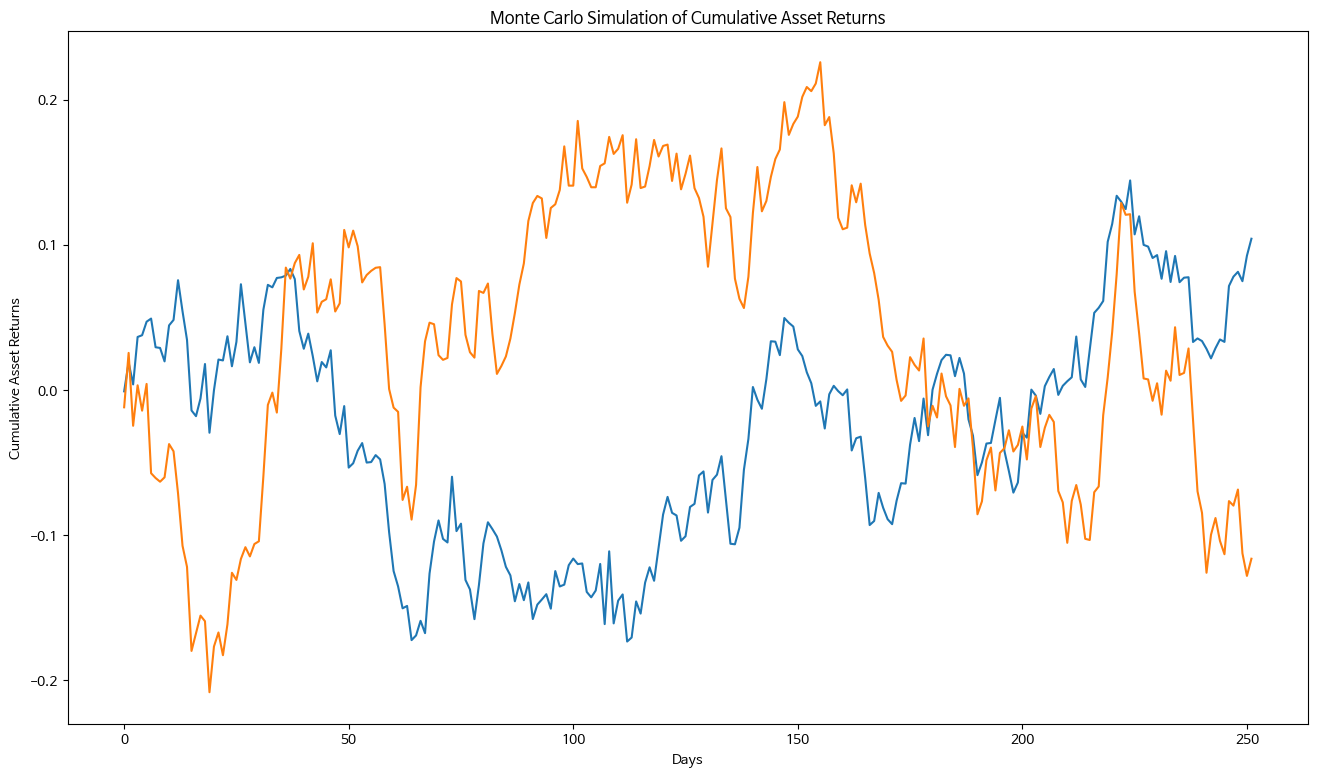

In [ ]:
"""
cumulative_log_returns = np.cumsum(simulated_returns, axis=1)
print(cumulative_log_returns.shape)

# 결과 시각화
plt.figure(figsize=(16, 9))
plt.plot(cumulative_log_returns[0, :], label='Samsumg')
plt.plot(cumulative_log_returns[1, :], label='Skhynix')
plt.title('Monte Carlo Simulation of Cumulative Asset Returns')
plt.xlabel('Days')
plt.ylabel('Cumulative Asset Returns')
plt.show() 
"""
